Baseline model with engineered features, scaling & __NO__ threshold tuning

Categorical columns: ['Sex', 'Embarked', 'Title']
Numeric columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'AgeMissing']


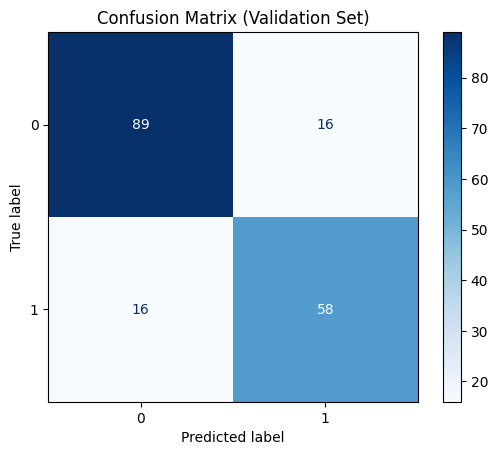

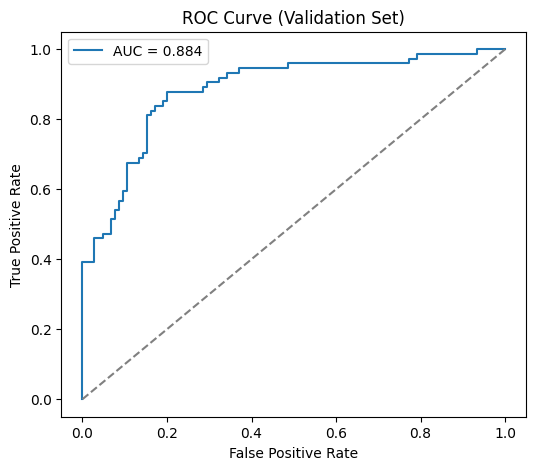

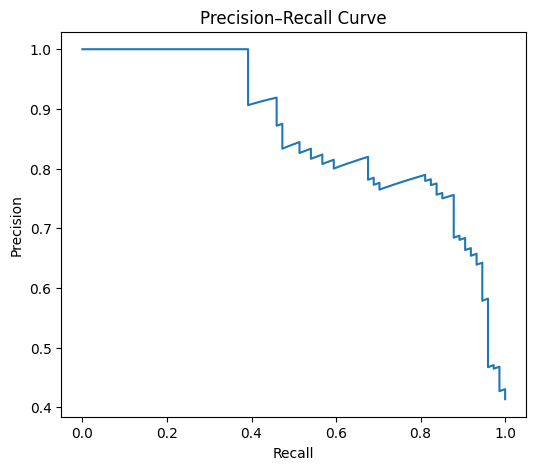

Top 100 features:
           feature      coef  abs_coef
0    Title_Master  1.828396  1.828396
1        Title_Mr -1.119327  1.119327
2      Sex_female  0.935908  0.935908
3          Pclass -0.911885  0.911885
4        Sex_male -0.872551  0.872551
5   Title_Officer -0.767667  0.767667
6       Title_Mrs  0.669992  0.669992
7           SibSp -0.563300  0.563300
8   Title_Royalty -0.443078  0.443078
9             Age -0.423392  0.423392
10          Parch -0.267383  0.267383
11     Embarked_S -0.242177  0.242177
12     Embarked_C  0.171798  0.171798
13           Fare  0.162852  0.162852
14     Embarked_Q  0.133734  0.133734
15     Title_Miss -0.104961  0.104961
16     AgeMissing -0.102246  0.102246 

Bottom 100 features:
           feature      coef  abs_coef
0    Title_Master  1.828396  1.828396
1        Title_Mr -1.119327  1.119327
2      Sex_female  0.935908  0.935908
3          Pclass -0.911885  0.911885
4        Sex_male -0.872551  0.872551
5   Title_Officer -0.767667  0.767667
6      

In [2]:
# ============================================================
# Baseline Model Using Engineered Features + One-Hot Encoding + Scaling
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)
import json

# ============================================================
# 1. Load processed datasets
# ============================================================

train = pd.read_csv("../data/processed_v2/train_features.csv")
test = pd.read_csv("../data/processed_v2/test_features.csv")

# Remove PassengerId from features but keep for submission
test_passenger_ids = test["PassengerId"]

# ============================================================
# 2. Identify feature columns
# ============================================================

y = train["Survived"]
X = train.drop(columns=["Survived", "PassengerId"])
X_test_final = test.drop(columns=["PassengerId"])

# ============================================================
# 3. Load categorical metadata
# ============================================================

with open("../data/processed_v2/processed_metadata.json", "r") as f:
    meta = json.load(f)

categorical_cols = list(meta.keys())
numeric_cols = [col for col in X.columns if col not in categorical_cols]

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# ============================================================
# 4. Preprocessing: One-Hot + Scaling
# ============================================================

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

# ============================================================
# 5. Build Logistic Regression pipeline
# ============================================================

model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("logreg", LogisticRegression(max_iter=2000))
    ]
)

# ============================================================
# 6. Train/validation split
# ============================================================

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================================
# 7. Train baseline model
# ============================================================

model.fit(X_train, y_train)

# Predict class labels and probabilities
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

# ============================================================
# 8. Confusion Matrix
# ============================================================

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# ============================================================
# 9. ROC Curve
# ============================================================

fpr, tpr, _ = roc_curve(y_val, y_proba)
auc = roc_auc_score(y_val, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend()
plt.show()

# ============================================================
# 10. Precision–Recall Curve
# ============================================================

precision, recall, _ = precision_recall_curve(y_val, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

# ============================================================
# 11. Train final model & extract feature importances
# ============================================================

model.fit(X, y)

import numpy as np
import pandas as pd

# ============================================================
# Extract feature names after preprocessing
# ============================================================

preprocess = model.named_steps["preprocess"]

# One-Hot Encoder
ohe = preprocess.named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(categorical_cols)

# Scaled numeric feature names (same order as input)
numeric_features = numeric_cols

# Combined feature list
all_features = np.concatenate([ohe_features, numeric_features])

# ============================================================
# Extract Logistic Regression coefficients
# ============================================================

logreg = model.named_steps["logreg"]
coefs = logreg.coef_.ravel()

coef_df = (
    pd.DataFrame({
        "feature": all_features,
        "coef": coefs,
        "abs_coef": np.abs(coefs)
    })
    .sort_values("abs_coef", ascending=False)
    .reset_index(drop=True)
)

# Show the strongest + weakest signals
print("Top 100 features:\n", coef_df.head(100), "\n")
print("Bottom 100 features:\n", coef_df.tail(100), "\n")

# Extract bottom 100 feature names
bottom_100 = coef_df.tail(100)["feature"].tolist()

# Print them in quoted, comma-separated format
for f in bottom_100:
    print(f'"{f}",')

# Optional: save coefficients
coef_df.to_csv("../submissions/feature_importances_lr.csv", index=False)

# ============================================================
# 12. Predict test set & create submission
# ============================================================

test_predictions = model.predict(X_test_final)

submission = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": test_predictions
})

submission_path = "../submissions/submission_engineered_baseline_scaled.csv"
submission.to_csv(submission_path, index=False)

print(f"Ready for Kaggle: {submission_path}")
print("Feature coefficients saved to: ../submissions/feature_importances_lr.csv")
